In [1]:
from stack import *

In [93]:
inst = 1
ifield = 4
m_min, m_max = 16,17
stack = stacking(inst, ifield, m_min, m_max, load_from_file=True)

stacking elat10 16 < m < 17, #0 BG, 79 sources, t = 0.00 min
stacking elat10 16 < m < 17, #1 BG, 79 sources, t = 0.14 min
stacking elat10 16 < m < 17, #2 BG, 79 sources, t = 0.28 min
stacking elat10 16 < m < 17, #3 BG, 79 sources, t = 0.43 min
stacking elat10 16 < m < 17, #4 BG, 79 sources, t = 0.65 min
stacking elat10 16 < m < 17, #5 BG, 79 sources, t = 0.81 min
stacking elat10 16 < m < 17, #6 BG, 79 sources, t = 0.95 min
stacking elat10 16 < m < 17, #7 BG, 79 sources, t = 1.10 min
stacking elat10 16 < m < 17, #8 BG, 79 sources, t = 1.30 min
stacking elat10 16 < m < 17, #9 BG, 79 sources, t = 1.45 min


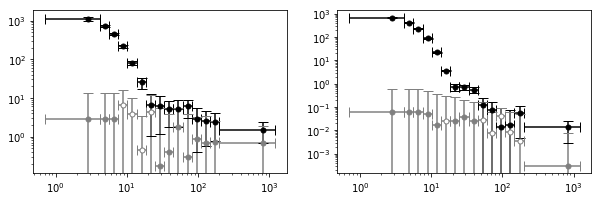

In [94]:
from utils_plotting import * 

fig, ax = plt.subplots(1,2,figsize=(10,3))
plot_err_log(stack.stackdat['rsubbins'], 
             stack.stackdat['profcbsub'],
             np.sqrt(np.diag(stack.stackdat['cov']['profcbsub'])),
             xedges=stack.stackdat['rsubbinedges'],
             ax=ax[0])
plot_err_log(stack.stackdat['rsubbins'], 
             stack.stackdat['BG']['profcbsub'],
             np.sqrt(np.diag(stack.stackdat['BGcov']['profcbsub'])),
             xedges=stack.stackdat['rsubbinedges'],
             color='grey',
             ax=ax[0])
plot_err_log(stack.stackdat['rsubbins'], 
             stack.stackdat['profpssub'],
             np.sqrt(np.diag(stack.stackdat['cov']['profpssub'])),
             xedges=stack.stackdat['rsubbinedges'],
             ax=ax[1])
plot_err_log(stack.stackdat['rsubbins'], 
             stack.stackdat['BG']['profpssub'],
             np.sqrt(np.diag(stack.stackdat['BGcov']['profpssub'])),
             xedges=stack.stackdat['rsubbinedges'],
             color='grey',
             ax=ax[1])

# ax[0].set_xscale('linear')
# ax[1].set_yscale('linear')

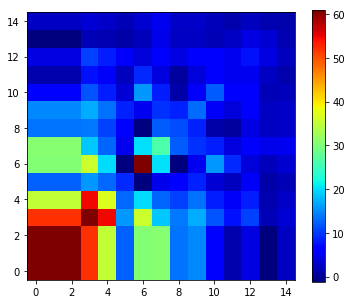

In [95]:
imageclip(stack.stackdat['BGcov']['profcbsub'])

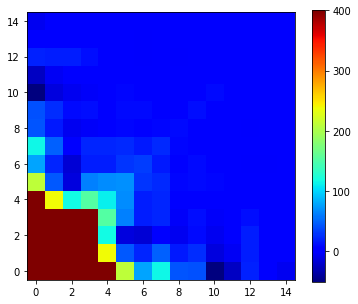

In [96]:
imageclip(stack.stackdat['cov']['profcbsub'])

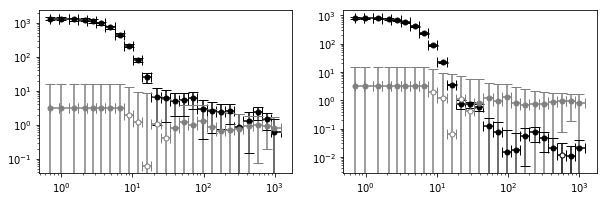

In [84]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plot_err_log(stack.stackdat['rbins'], 
             stack.stackdat['profcb'],
             np.sqrt(np.diag(stack.stackdat['cov']['profcb'])),
             xedges=stack.stackdat['rbinedges'],
             ax=ax[0])
plot_err_log(stack.stackdat['rbins'], 
             stack.stackdat['BG']['profcb'],
             np.sqrt(np.diag(stack.stackdat['BGcov']['profcb'])),
             xedges=stack.stackdat['rbinedges'],
             color='grey',
             ax=ax[0])
plot_err_log(stack.stackdat['rbins'], 
             stack.stackdat['profps'],
             np.sqrt(np.diag(stack.stackdat['cov']['profps'])),
             xedges=stack.stackdat['rbinedges'],
             ax=ax[1])
plot_err_log(stack.stackdat['rbins'], 
             stack.stackdat['BG']['profps'],
             np.sqrt(np.diag(stack.stackdat['BGcov']['profps'])),
             xedges=stack.stackdat['rbinedges'],
             color='grey',
             ax=ax[1])

# ax[0].set_xscale('linear')
# ax[1].set_yscale('linear')

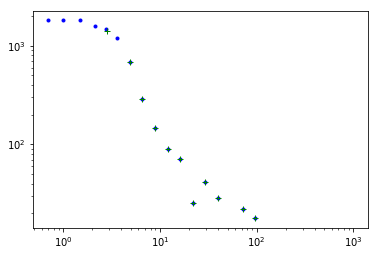

In [100]:
for i in [0]:#range(stack.stackdat['Nsub']):
    plt.loglog(stack.stackdat['rbins'],stack.stackdat['sub'][i]['profcb'],'b.')
    plt.loglog(stack.stackdat['rsubbins'],stack.stackdat['sub'][i]['profcbsub'],'g+')
# plt.loglog(stack.stackdat['rbins'],stack.stackdat['profcb'],'ko')
# plt.loglog(stack.stackdat['rsubbins'],stack.stackdat['profcbsub'],'g+')

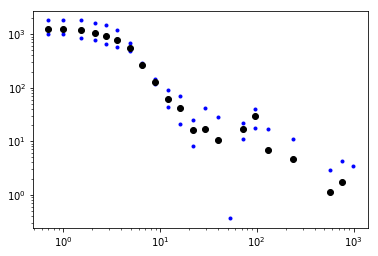

In [91]:
for i in [0,1]:#range(stack.stackdat['Nsub']):
    plt.loglog(stack.stackdat['rbins'],stack.stackdat['sub'][i]['profcb'],'b.')
plt.loglog(stack.stackdat['rbins'],stack.stackdat['profcb'],'ko')